In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import math
import numpy as np
import torch as T
import matplotlib.pyplot as plt

In [3]:
dataset_path = "datasets/MiniGrid-SimpleCrossingS11N5-v0-CrossingS11N5_A2C_Fullgrid-10.pickle"

In [4]:
with open(dataset_path, 'rb') as handle:
    data = pickle.load(handle)

In [5]:
data[9][3]['obs'].keys()

dict_keys(['image', 'direction', 'mission', 'partial_image', 'pixels', 'partial_pixels'])

In [6]:
data[0].keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34])

In [7]:
print([data[0][i]['action'] for i in range(len(data[0]))])

[2, 2, 2, 2, 2, 4, 5, 6, 2, 5, 5, 1, 2, 5, 4, 2, 3, 0, 2, 1, 2, 5, 2, 5, 2, 2, 0, 4, 2, 2, 1, 2, 3, 3, 2]


In [8]:
data[0][11]['direction']

0

In [9]:
data[0][12]['direction']

1

In [10]:
np.allclose(data[0][11]['obs']['partial_image'], data[0][12]['obs']['partial_image'])

False

In [11]:
data[0][11]['obs']['image'][:,:,0]

array([[ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2],
       [ 2,  1,  2,  1,  2,  1,  1,  1,  2,  1,  2],
       [ 2,  1,  2,  1,  2,  1,  1,  1,  2,  1,  2],
       [ 2,  1,  2,  1,  2,  1,  1,  1,  2,  1,  2],
       [ 2,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2],
       [ 2,  1,  2,  1,  2,  1,  1,  1,  2,  1,  2],
       [ 2,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2],
       [ 2, 10,  1,  1,  2,  1,  1,  1,  2,  1,  2],
       [ 2,  1,  2,  1,  1,  1,  1,  1,  2,  1,  2],
       [ 2,  1,  2,  1,  2,  1,  1,  1,  1,  8,  2],
       [ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2]], dtype=uint8)

In [12]:
 data[0][12]['obs']['image'][:,:,0]

array([[ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2],
       [ 2,  1,  2,  1,  2,  1,  1,  1,  2,  1,  2],
       [ 2,  1,  2,  1,  2,  1,  1,  1,  2,  1,  2],
       [ 2,  1,  2,  1,  2,  1,  1,  1,  2,  1,  2],
       [ 2,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2],
       [ 2,  1,  2,  1,  2,  1,  1,  1,  2,  1,  2],
       [ 2,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2],
       [ 2, 10,  1,  1,  2,  1,  1,  1,  2,  1,  2],
       [ 2,  1,  2,  1,  1,  1,  1,  1,  2,  1,  2],
       [ 2,  1,  2,  1,  2,  1,  1,  1,  1,  8,  2],
       [ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2]], dtype=uint8)

In [13]:
 data[0][12]['location']

array([7, 1])

In [14]:
T.Tensor([data[episode][step]['direction'] for episode in range(len(data)) for step in range(len(data[episode]))]).shape

torch.Size([481])

In [15]:
support_trajectories = T.Tensor(np.array([data[episode][step]['obs']['partial_pixels'] for episode in range(len(data)) for step in range(len(data[episode]))]))
support_targets = T.tensor(np.array([episode for episode in range(len(data)) for step in range(len(data[episode]))]))

In [16]:
for target in support_targets.unique():
    trajectory=support_trajectories[support_targets==target]
    print(trajectory.shape)

torch.Size([35, 3, 56, 56])
torch.Size([22, 3, 56, 56])
torch.Size([76, 3, 56, 56])
torch.Size([69, 3, 56, 56])
torch.Size([43, 3, 56, 56])
torch.Size([40, 3, 56, 56])
torch.Size([52, 3, 56, 56])
torch.Size([39, 3, 56, 56])
torch.Size([36, 3, 56, 56])
torch.Size([69, 3, 56, 56])


In [20]:
from generative_contrastive_modelling.gcm_encoder import GCMEncoder
from generative_contrastive_modelling.gcm import GenerativeContrastiveModelling

GCM = GenerativeContrastiveModelling(support_trajectories.shape, 64, 64)
gcm_encoder = GCMEncoder(support_trajectories.shape, 64, 64)

TypeError: __init__() missing 2 required positional arguments: 'use_location' and 'use_direction'

In [21]:
gcm_encoder.forward(support_trajectories)

NameError: name 'gcm_encoder' is not defined

In [22]:
from generative_contrastive_modelling.proto_encoder import ProtoEncoder
from generative_contrastive_modelling.protonet import PrototypicalNetwork

proto_encoder = ProtoEncoder(support_trajectories.shape, 64, 64)
protonet = PrototypicalNetwork(support_trajectories.shape, 64, 64)

TypeError: __init__() missing 2 required positional arguments: 'use_location' and 'use_direction'

In [23]:
proto_encoder.forward(support_trajectories)

NameError: name 'proto_encoder' is not defined

In [24]:
indices = T.randperm(support_trajectories.shape[0])[:5]
query_observations = support_trajectories[indices]
query_targets = support_targets[indices]

In [25]:
query_targets

tensor([9, 8, 9, 4, 6])

In [26]:
observations=T.cat([support_trajectories, query_observations], dim=0)

In [27]:
GCM.compute_loss(support_trajectories=support_trajectories, support_targets=support_targets, query_observations=query_observations, query_targets=query_targets)

TypeError: compute_loss() got an unexpected keyword argument 'support_targets'

In [28]:
protonet.compute_loss(support_trajectories=support_trajectories, support_targets=support_targets, query_observations=query_observations, query_targets=query_targets)

NameError: name 'protonet' is not defined

In [29]:
support_targets.squeeze_(0).shape

torch.Size([481])

In [30]:
support_targets.shape

torch.Size([481])

In [31]:
data[0][11]['obs']['partial_pixels'].shape

(3, 56, 56)

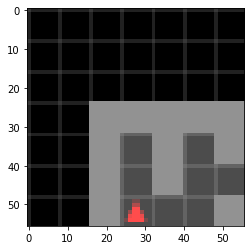

In [32]:
plt.imshow(data[0][11]['obs']['partial_pixels'].transpose(1,2,0))

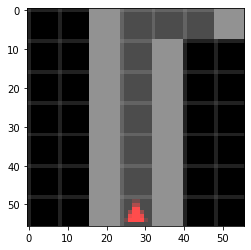

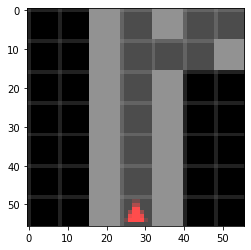

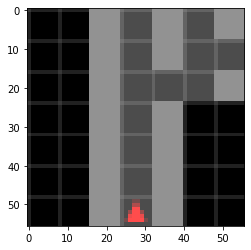

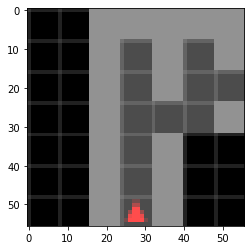

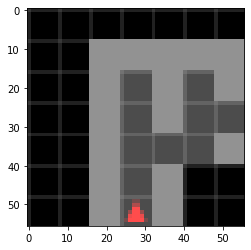

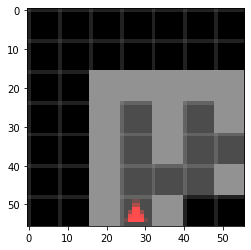

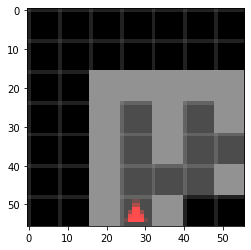

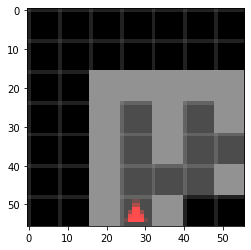

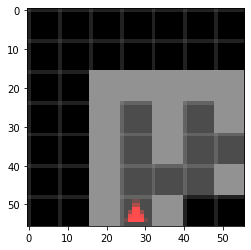

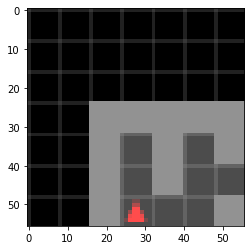

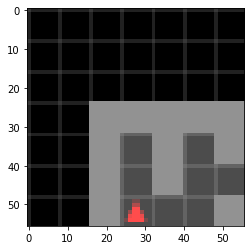

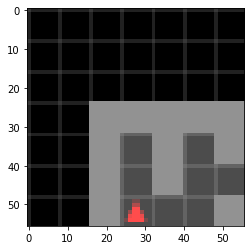

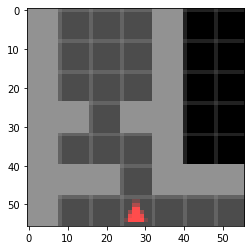

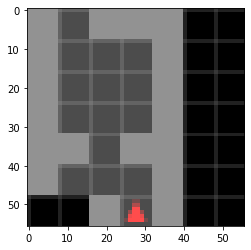

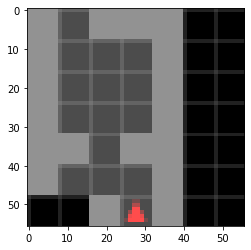

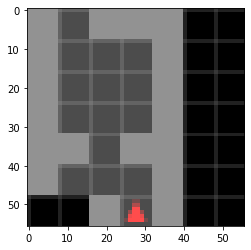

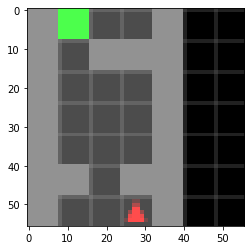

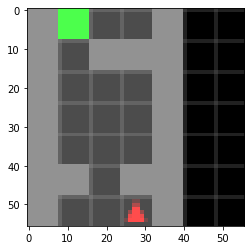

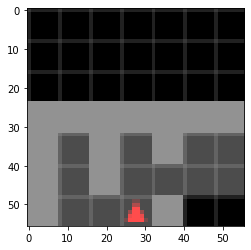

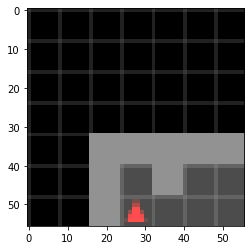

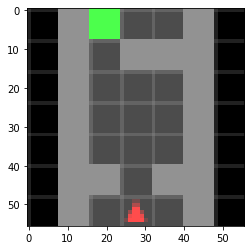

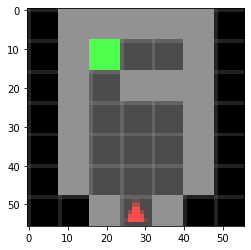

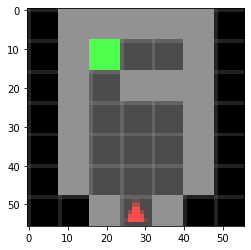

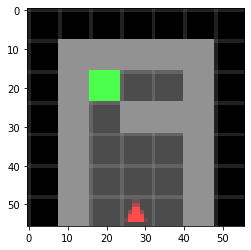

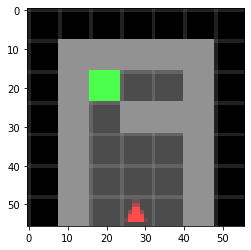

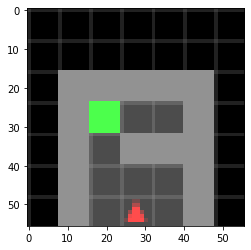

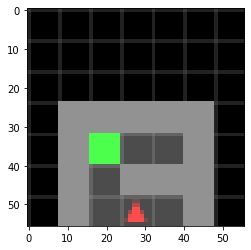

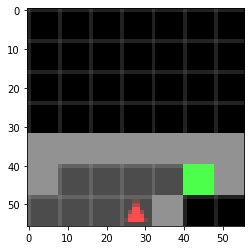

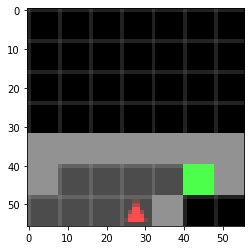

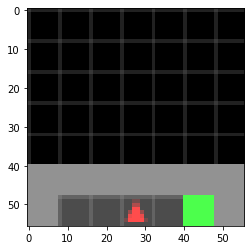

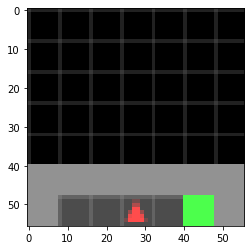

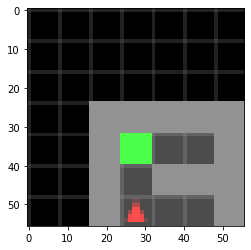

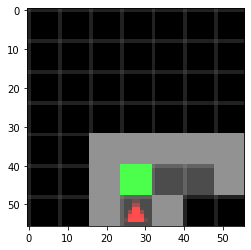

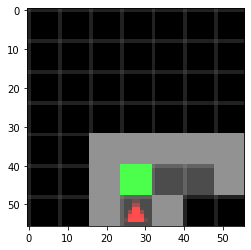

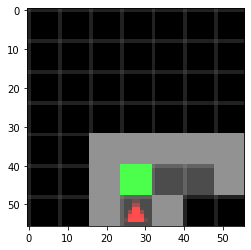

In [33]:
for i in range(len(data[0])):
    plt.imshow(data[0][i]['obs']['partial_pixels'].transpose(1,2,0))
    plt.show()

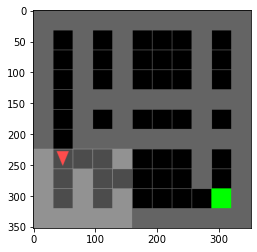

In [34]:
plt.imshow(data[0][11]['obs']['pixels'].transpose(2,1,0))

In [35]:
data[0][11]['obs']['partial_pixels'].transpose(2,1,0).shape

(56, 56, 3)

In [7]:
from generate_trajectories import generate_data

In [1]:
import minigrid_rl_starter.utils as utils
# Load environment

env = utils.make_env("MiniGrid-SimpleCrossingS11N5-v0", 0)
for _ in range(0):
    env.reset()
env_copy = utils.make_env("MiniGrid-SimpleCrossingS11N5-v0", 0)
for _ in range(0):
    env_copy.reset()
print("Environment loaded\n")

# Load agent

trained_model_dir = utils.get_model_dir("CrossingS11N5_A2C_Fullgrid", storage_dir="minigrid_rl_starter")
exploratory_model_dir = utils.get_model_dir("CrossingS11N5_A2C_state_bonus_fullgrid", storage_dir="minigrid_rl_starter")

trained_agent = utils.Agent(
    env.observation_space,
    env.action_space,
    trained_model_dir,
    argmax=True,
    use_memory=False,
    use_text=False,
)
print("Trained agent loaded\n")

exploratory_agent = utils.Agent(
    env.observation_space,
    env.action_space,
    exploratory_model_dir,
    argmax=True,
    use_memory=False,
    use_text=False,
)
print("Exploratory agent loaded\n")

Environment loaded



RuntimeError: Error(s) in loading state_dict for ACModel:
	size mismatch for actor.2.weight: copying a param with shape torch.Size([7, 64]) from checkpoint, the shape in current model is torch.Size([3, 64]).
	size mismatch for actor.2.bias: copying a param with shape torch.Size([7]) from checkpoint, the shape in current model is torch.Size([3]).

In [146]:
train_dataset = generate_data(env=env, agent=trained_agent, episodes=5, render=False)

In [147]:
query_dataset = generate_data(env=env_copy, agent=exploratory_agent, episodes=5, render=False)

In [15]:
query_trajectories = T.Tensor(
            np.array(
                [
                    query_dataset[episode][step]["obs"]["partial_pixels"]
                    for episode in range(len(query_dataset))
                    for step in range(len(query_dataset[episode]))
                ]
            )
        )
query_targets = T.tensor(
            np.array(
                [
                    episode
                    for episode in range(len(query_dataset))
                    for step in range(len(query_dataset[episode]))
                ]
            )
        )
indices = T.randperm(query_trajectories.shape[0])[: 5]
query_observations = query_trajectories[indices]
query_targets = query_targets[indices]

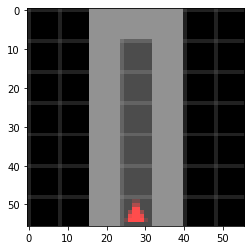

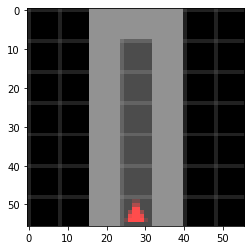

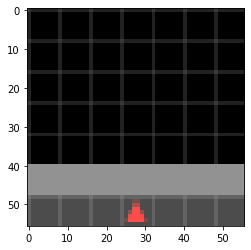

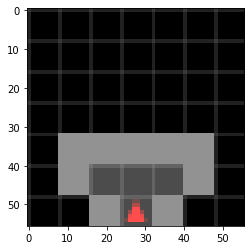

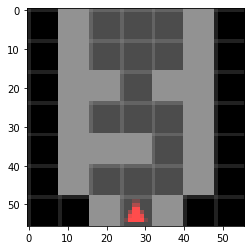

In [41]:
for i in range(query_observations.shape[0]):
    plt.imshow(query_observations[i].permute(1,2,0)/255.0)
    plt.show()

In [42]:
query_targets

tensor([1, 0, 0, 3, 3])

In [43]:
T.randperm(4)

tensor([1, 2, 0, 3])

In [44]:
query_environments = T.Tensor(
            np.array(
                [
                    query_dataset[episode][step]["obs"]["pixels"]
                    for episode in range(len(query_dataset))
                    for step in range(len(query_dataset[episode]))
                ]
            )
        )
query_environments = query_environments[indices]

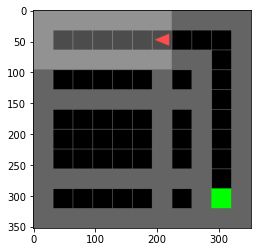

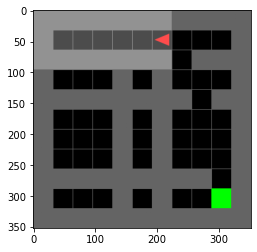

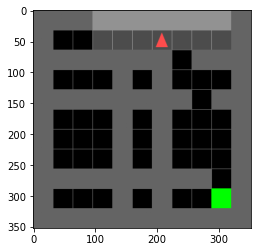

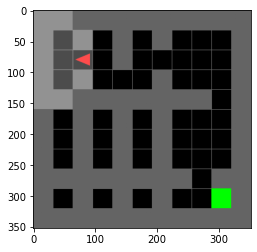

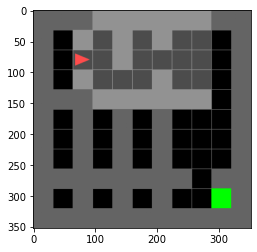

In [45]:
for i in range(query_environments.shape[0]):
    plt.imshow(query_environments[i].permute(1,2,0)/255.0)
    plt.show()

In [46]:
train_directions=T.Tensor(np.array(
                [
                    train_dataset[episode][step]["direction"]
                    for episode in range(len(train_dataset))
                    for step in range(len(train_dataset[episode]))
                ]
 )).to(T.int64)

query_directions=T.Tensor(np.array(
                [
                    query_dataset[episode][step]["direction"]
                    for episode in range(len(query_dataset))
                    for step in range(len(query_dataset[episode]))
                ]
 )).to(T.int64)

In [47]:
np.bincount(train_directions)

array([523,  44,   3])

In [48]:
np.bincount(query_directions)

array([ 617, 1085,  360,  358])

In [16]:
directions = T.Tensor(
    np.array(
        [
            query_dataset[episode][step]["direction"]
            for episode in range(len(query_dataset))
            for step in range(len(query_dataset[episode]))
        ]
    )
).to(T.int64)

In [23]:
indices = T.randperm(directions.shape[0])[:5]
directions[directions!=directions[indices]]

RuntimeError: The size of tensor a (2420) must match the size of tensor b (5) at non-singleton dimension 0

In [44]:
from process_trajectories import data_to_tensors, sample_views

In [48]:
train_trajectory=data_to_tensors(train_dataset)

In [77]:
indices, query_views= sample_views(train_trajectory,5)

In [47]:
count=0
for view in query_views['observations']:
    for i in range(len(train_trajectory['observations'])):
        if T.allclose(train_trajectory['observations'][i],view):
            count+=1
print(count)
print(len(train_trajectory['observations']))

1898
570


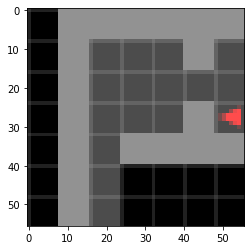

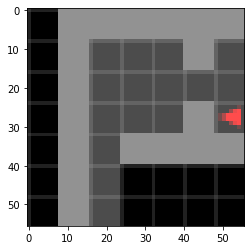

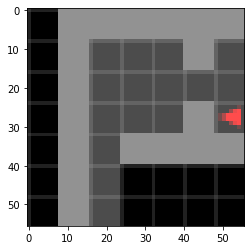

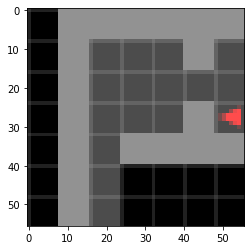

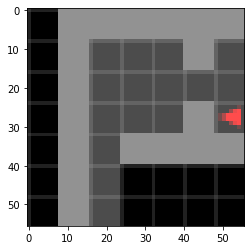

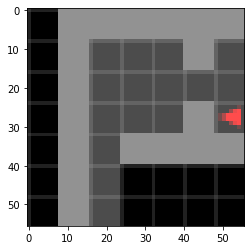

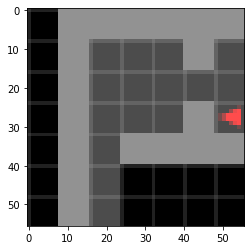

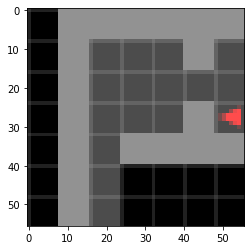

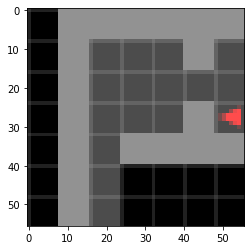

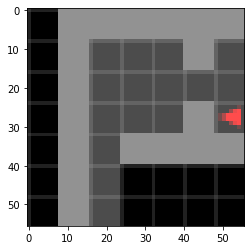

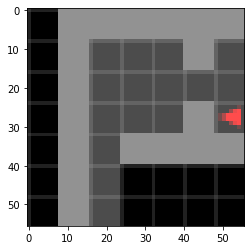

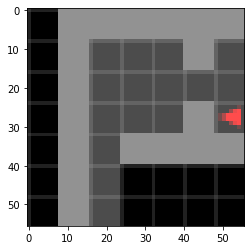

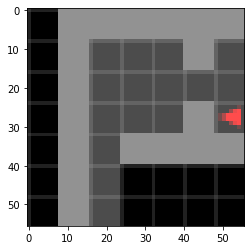

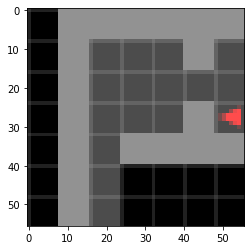

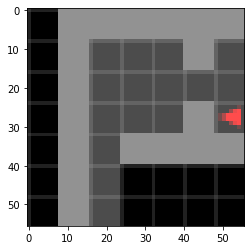

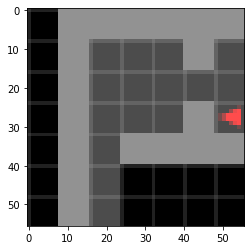

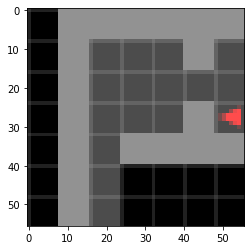

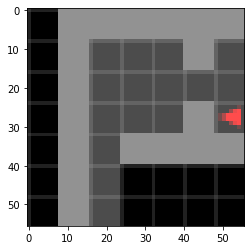

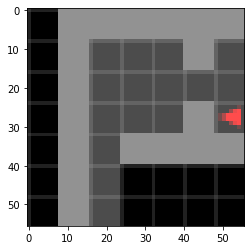

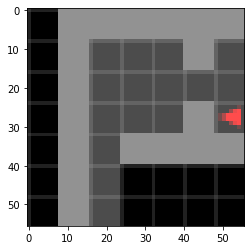

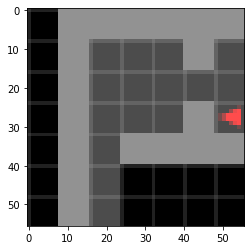

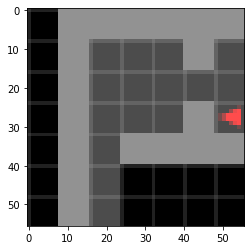

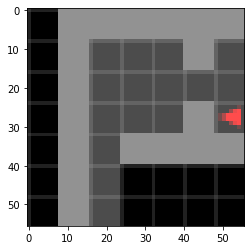

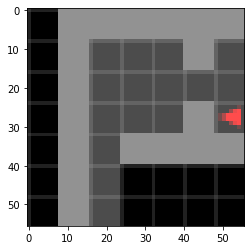

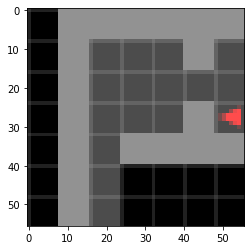

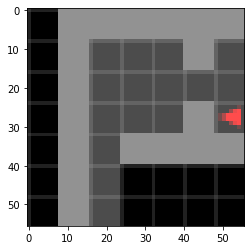

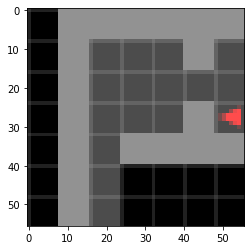

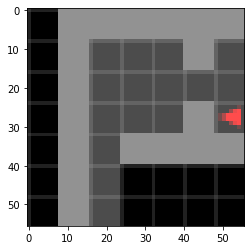

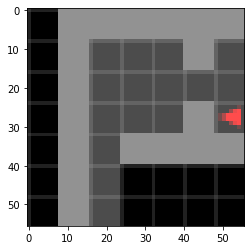

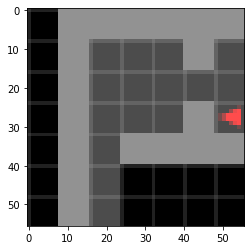

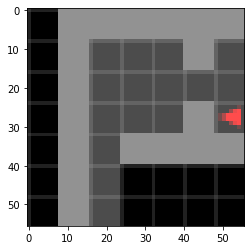

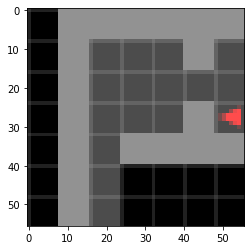

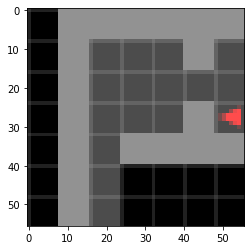

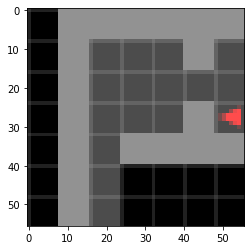

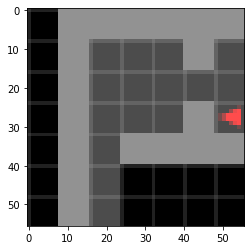

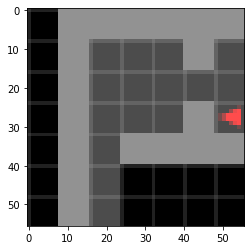

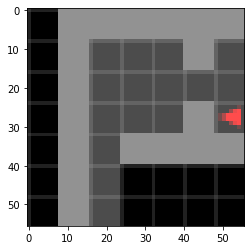

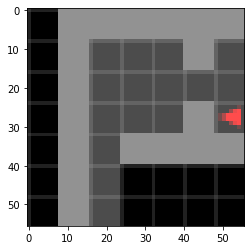

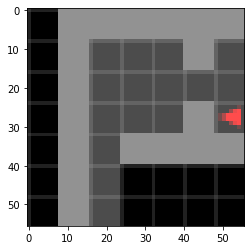

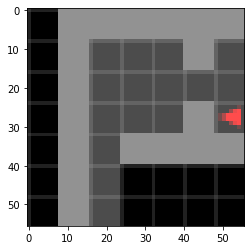

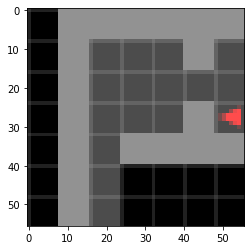

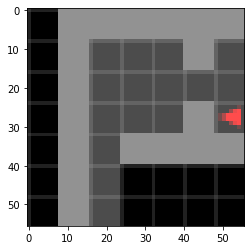

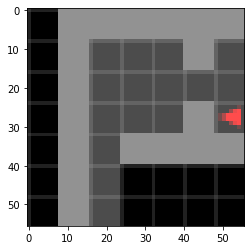

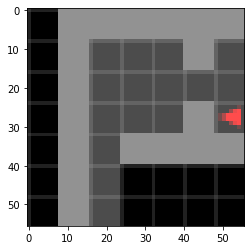

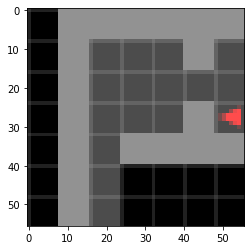

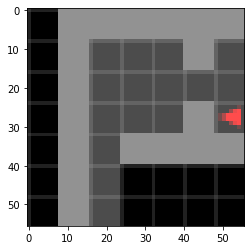

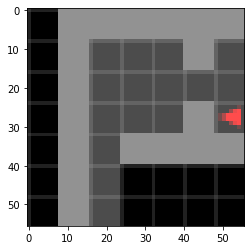

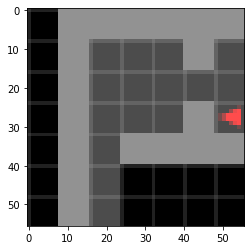

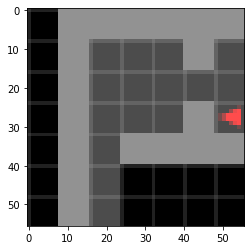

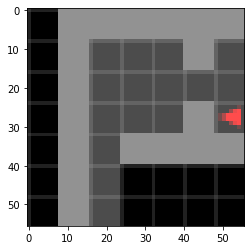

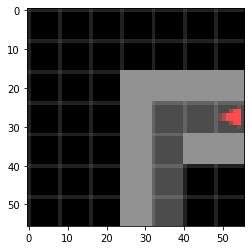

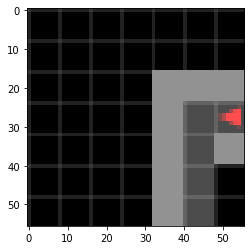

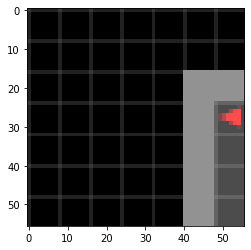

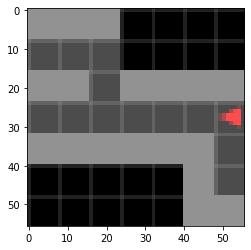

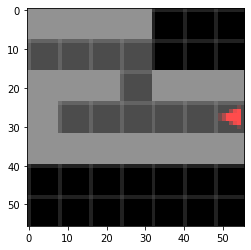

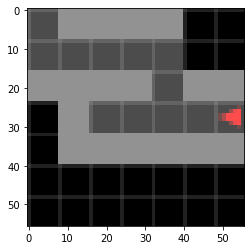

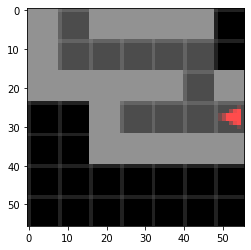

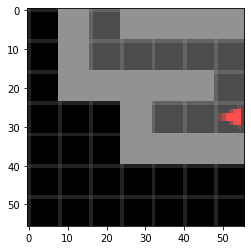

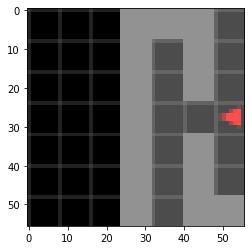

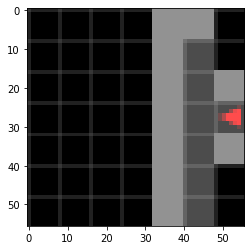

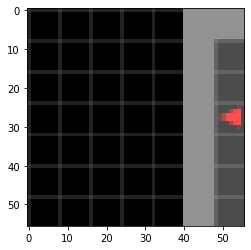

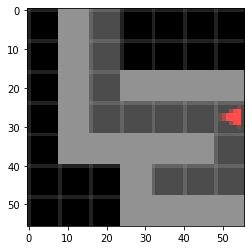

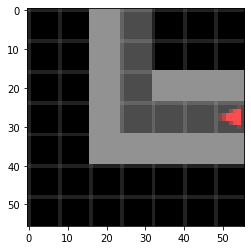

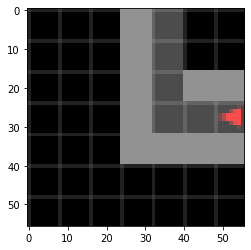

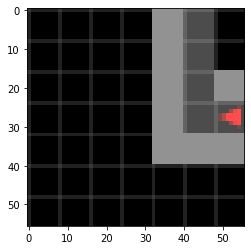

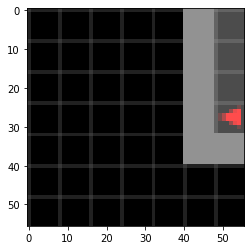

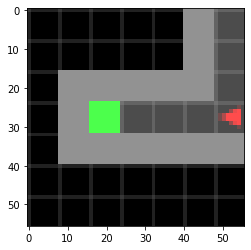

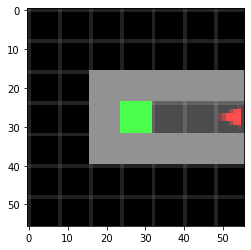

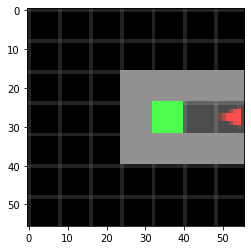

In [132]:
for i in range(500,569):
    plt.imshow(train_trajectory['observations'][i].transpose(2,0)/255.0)
    plt.show()

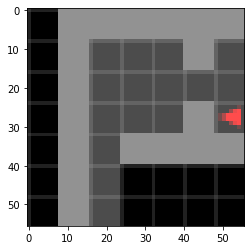

In [81]:
plt.imshow(query_views['observations'][0].transpose(2,0)/255.0)

In [85]:
T.allclose(query_views['observations'][0], train_trajectory['observations'][366])

True

In [34]:
support_obs = T.Tensor(np.array(
                [
                    train_dataset[episode][step]["obs"]["partial_pixels"] 
                    for episode in range(len(train_dataset)) 
                    for step in range(len(train_dataset[episode])) if step%5!=0
                ]
            )
        )

In [35]:
support_obs.shape

torch.Size([454, 3, 56, 56])

In [36]:
query_idx = np.array([i for i in range(len(support_obs)) if i%5==0])

In [37]:
support_idx = np.array([i for i in range(len(support_obs)) if i%5!=0])

In [38]:
len(support_idx)

363

In [39]:
len(query_idx)

91

In [41]:
indices = T.randperm(support_obs.shape[0])[:5]
indices

tensor([351, 336, 418, 302, 396])

In [42]:
remaining_indices = T.tensor([i for i in range(support_obs.shape[0]) if i not in indices])

In [44]:
len(remaining_indices)

449

In [49]:
query_views, support_trajectories = sample_views(train_trajectory,100)

In [51]:
query_views['observations'].shape

torch.Size([100, 3, 56, 56])

In [53]:
for i in range(query_views['observations'].shape[0]):
    for j in range(support_trajectories['observations'].shape[0]):
        if T.allclose(query_views['observations'][i], support_trajectories['observations'][j]):
            print('ok')

ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
o

In [2]:
import minigrid_rl_starter.utils as utils
# Load environment

env = utils.make_env("MiniGrid-SimpleCrossingS11N5-v0", 0)
for _ in range(0):
    env.reset()
env_copy = utils.make_env("MiniGrid-SimpleCrossingS11N5-v0", 0)
for _ in range(0):
    env_copy.reset()
print("Environment loaded\n")

# Load agent

trained_model_dir = utils.get_model_dir("CrossingS11N5_A2C_fullgrid_navigation", storage_dir="minigrid_rl_starter")
exploratory_model_dir = utils.get_model_dir("CrossingS11N5_A2C_fullgrid_navigation_state_bonus", storage_dir="minigrid_rl_starter")

trained_agent = utils.Agent(
    env.observation_space,
    env.action_space,
    trained_model_dir,
    argmax=True,
    use_memory=False,
    use_text=False,
)
print("Trained agent loaded\n")

exploratory_agent = utils.Agent(
    env.observation_space,
    env.action_space,
    exploratory_model_dir,
    argmax=True,
    use_memory=False,
    use_text=False,
)
print("Exploratory agent loaded\n")

Environment loaded

Trained agent loaded

Exploratory agent loaded



In [8]:
train_dataset = generate_data(env=env, agent=trained_agent, episodes=5, render=False)

In [22]:
query_dataset = generate_data(env=env_copy, agent=exploratory_agent, episodes=5, render=False)

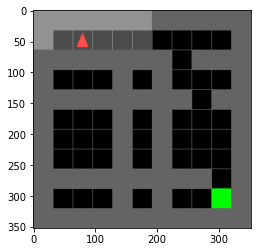

In [31]:
plt.imshow(query_dataset[0][14]['obs']['pixels'].transpose(1,2,0))

In [33]:
query_dataset[0][14]['direction']

3

In [42]:
import torch.nn.functional as F
F.one_hot(T.Tensor([2]).to(T.int64),4)

tensor([[0, 0, 1, 0]])

In [73]:
query_trajectories = data_to_tensors(query_dataset)

1


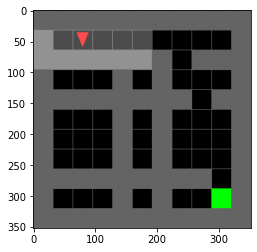

In [91]:
print(query_dataset[0][4]['direction'])
plt.imshow(query_dataset[0][4]['obs']['pixels'].transpose(1,2,0)/255.0)

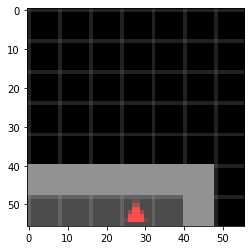

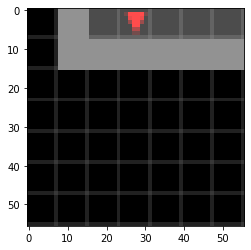

In [100]:
plt.imshow(orientated_trajectories['observations'][4].permute(1,2,0)/255.0)
plt.show()
plt.imshow(T.rot90(query_trajectories['observations'][4], 2, [1,2]).permute(1,2,0)/255.0)

In [94]:
def orientate_observations(trajectories):
    for i in range(len(trajectories['directions'])):
        if trajectories['directions'][i][0]==1:
            trajectories['observations'][i] = T.rot90(trajectories['observations'][i], -1, [1,2])
        elif trajectories['directions'][i][1]==1:
            trajectories['observations'][i] = T.rot90(trajectories['observations'][i], 2, [1,2])
        elif trajectories['directions'][i][2]==1:
            trajectories['observations'][i] = T.rot90(trajectories['observations'][i], 1, [1,2])
        elif trajectories['directions'][i][3]==1:
            pass
    return trajectories

In [98]:
orientated_trajectories = orientate_observations(query_trajectories)

In [99]:
orientated_trajectories['observations'][3]

tensor([[[ 0.,  0.,  0.,  ...,  0.,  0., 33.],
         [ 0.,  0.,  0.,  ...,  0.,  0., 33.],
         [ 0.,  0.,  0.,  ...,  0.,  0., 33.],
         ...,
         [ 0.,  0.,  0.,  ...,  0.,  0., 33.],
         [ 0.,  0.,  0.,  ...,  0.,  0., 33.],
         [33., 33., 33.,  ..., 33., 33., 55.]],

        [[ 0.,  0.,  0.,  ...,  0.,  0., 33.],
         [ 0.,  0.,  0.,  ...,  0.,  0., 33.],
         [ 0.,  0.,  0.,  ...,  0.,  0., 33.],
         ...,
         [ 0.,  0.,  0.,  ...,  0.,  0., 33.],
         [ 0.,  0.,  0.,  ...,  0.,  0., 33.],
         [33., 33., 33.,  ..., 33., 33., 55.]],

        [[ 0.,  0.,  0.,  ...,  0.,  0., 33.],
         [ 0.,  0.,  0.,  ...,  0.,  0., 33.],
         [ 0.,  0.,  0.,  ...,  0.,  0., 33.],
         ...,
         [ 0.,  0.,  0.,  ...,  0.,  0., 33.],
         [ 0.,  0.,  0.,  ...,  0.,  0., 33.],
         [33., 33., 33.,  ..., 33., 33., 55.]]])

In [19]:
env = utils.make_env("MiniGrid-SimpleCrossingS11N5-v0", 0)
for _ in range(0):
    env.reset()
env_copy = utils.make_env("MiniGrid-SimpleCrossingS11N5-v0", 0)
for _ in range(0):
    env_copy.reset()
print("Environment loaded\n")

Environment loaded



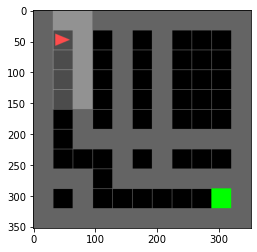

In [20]:
plt.imshow(env.render("rgb_array"))

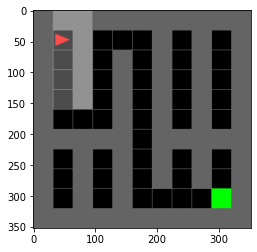

In [15]:
plt.imshow(env_copy.render("rgb_array"))

In [27]:
env = utils.make_env("MiniGrid-SimpleCrossingS11N5-v0", 0)
env.reset()

{'image': array([[[ 2,  5,  0],
         [ 2,  5,  0],
         [ 2,  5,  0],
         [ 2,  5,  0],
         [ 2,  5,  0],
         [ 2,  5,  0],
         [ 2,  5,  0],
         [ 2,  5,  0],
         [ 2,  5,  0],
         [ 2,  5,  0],
         [ 2,  5,  0]],
 
        [[ 2,  5,  0],
         [10,  0,  0],
         [ 2,  5,  0],
         [ 1,  0,  0],
         [ 2,  5,  0],
         [ 1,  0,  0],
         [ 1,  0,  0],
         [ 1,  0,  0],
         [ 2,  5,  0],
         [ 1,  0,  0],
         [ 2,  5,  0]],
 
        [[ 2,  5,  0],
         [ 1,  0,  0],
         [ 2,  5,  0],
         [ 1,  0,  0],
         [ 2,  5,  0],
         [ 1,  0,  0],
         [ 1,  0,  0],
         [ 1,  0,  0],
         [ 2,  5,  0],
         [ 1,  0,  0],
         [ 2,  5,  0]],
 
        [[ 2,  5,  0],
         [ 1,  0,  0],
         [ 2,  5,  0],
         [ 1,  0,  0],
         [ 2,  5,  0],
         [ 1,  0,  0],
         [ 1,  0,  0],
         [ 1,  0,  0],
         [ 2,  5,  0],
         [ 1,  0

In [40]:
env = utils.make_env("MiniGrid-SimpleCrossingS11N5-v0", 1)
env_copy = utils.make_env("MiniGrid-SimpleCrossingS11N5-v0", 1)
env_copy.reset()
env.reset()
np.allclose(env.reset()['image'], env_copy.reset()['image'])

True

In [34]:
env.reset()

{'image': array([[[ 2,  5,  0],
         [ 2,  5,  0],
         [ 2,  5,  0],
         [ 2,  5,  0],
         [ 2,  5,  0],
         [ 2,  5,  0],
         [ 2,  5,  0],
         [ 2,  5,  0],
         [ 2,  5,  0],
         [ 2,  5,  0],
         [ 2,  5,  0]],
 
        [[ 2,  5,  0],
         [10,  0,  0],
         [ 2,  5,  0],
         [ 1,  0,  0],
         [ 2,  5,  0],
         [ 1,  0,  0],
         [ 1,  0,  0],
         [ 1,  0,  0],
         [ 2,  5,  0],
         [ 1,  0,  0],
         [ 2,  5,  0]],
 
        [[ 2,  5,  0],
         [ 1,  0,  0],
         [ 2,  5,  0],
         [ 1,  0,  0],
         [ 2,  5,  0],
         [ 1,  0,  0],
         [ 1,  0,  0],
         [ 1,  0,  0],
         [ 2,  5,  0],
         [ 1,  0,  0],
         [ 2,  5,  0]],
 
        [[ 2,  5,  0],
         [ 1,  0,  0],
         [ 2,  5,  0],
         [ 1,  0,  0],
         [ 2,  5,  0],
         [ 1,  0,  0],
         [ 1,  0,  0],
         [ 1,  0,  0],
         [ 2,  5,  0],
         [ 1,  0

In [1]:
import wandb
api = wandb.Api()

run_exp = api.run("adamjelley/gen-con-rl/2on3lyxa")
run_sin= api.run("adamjelley/gen-con-rl/tkclcaor")

run_exp.config = run_sin.config
run_exp.config["exploratory_agent"] = "CrossingS11N5_A2C_fullgrid_navigation_state_bonus"
run_exp.update()

In [5]:
import torch as T
def euclidian_distances(prototypes, embeddings):
    distances = T.sum(
        (prototypes.unsqueeze(2) - embeddings.unsqueeze(1)) ** 2, dim=-1
    )
    return distances

In [6]:
proto=T.rand(1,10,128)
embeddings=T.rand(1,100,128)
euclidian_distances(proto, embeddings).shape

torch.Size([1, 10, 100])